### Don't Rerun below (it's slow 46mins)

In [62]:
from ipynb.fs.full.yt_web import get_video_data

In [13]:
from ipynb.fs.full.sentiment_small import flairPredict as predict_small

In [14]:
# from ipynb.fs.full.sentiment_large import flairPredict as predict_large

In [132]:
import collections
import matplotlib.pyplot as plt
import re
import numpy as np



In [15]:
score_to_text = {0:'BAD', 1:'GOOD'}
videos = get_video_data()

In [134]:
tags = [1, 2, 10, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]
id_to_tag =  {1:'Film & Animation',2:'Autos & Vehicles',10:'Music',15:'Pets & Animals',17:'Sports',18:'Short Movies',19:'Travel & Events',20:'Gaming',21:'Videoblogging',22:'People & Blogs',23:'Comedy',24:'Entertainment',25:'News & Politics',26:'Howto & Style',27:'Education',28:'Science & Technology',29:'Nonprofits & Activism',30:'Movies',31:'Anime/Animation',32:'Action/Adventure',33:'Classics',34:'Comedy',35:'Documentary',36:'Drama',37:'Family',38:'Foreign',39:'Horror',40:'Sci-Fi/Fantasy',41:'Thriller',42:'Shorts',43:'Shows',44:'Trailers'}
score_to_text = {0:'BAD', 1:'GOOD'}

In [17]:
sentence = "I love the way you explained, plus the diversity :)"
max_len = 30
sentence_pred = predict_small(sentence)
result = f'{score_to_text[sentence_pred]}: {sentence[:max_len]}...'
print(result)

sentence = "I hate the way you explained, plus no diversity"
sentence_pred = predict_small(sentence)
result = f'{score_to_text[sentence_pred]}: {sentence[:max_len]}...'
print(result)

GOOD: I love the way you explained, ...
BAD: I hate the way you explained, ...


In [31]:
for v in videos.values():
    print(id_to_tag[v.category_id])

Entertainment
Film & Animation
Entertainment
Sports
Music
Music
Sports
Entertainment
Music
Music


### Types of charts
#### tag -> sentiment ratio Sports [40% positive]  -- compare most positive tags
#### Word blob | comments / tag (all, pos, neg)
#### each tag, have most popular topics top 5: [soccer: fifa 60% pos , messi 80% pos] [music: bts]
#### comments/view_count / tag  = how enganging is a tag 
#### word generator


In [112]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
stop_words = set(stopwords.words('english'))
add_stop_words = ['im','wasnt', 'lets','going']
for w in add_stop_words:
    stop_words.add(w)

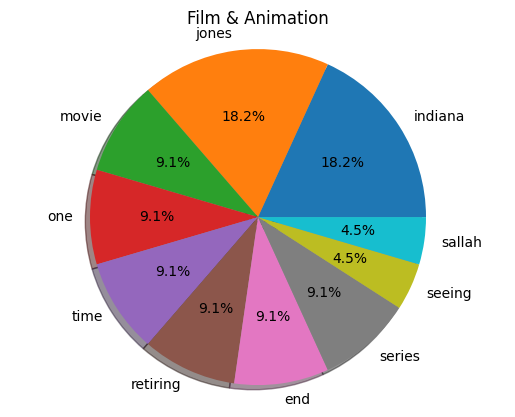

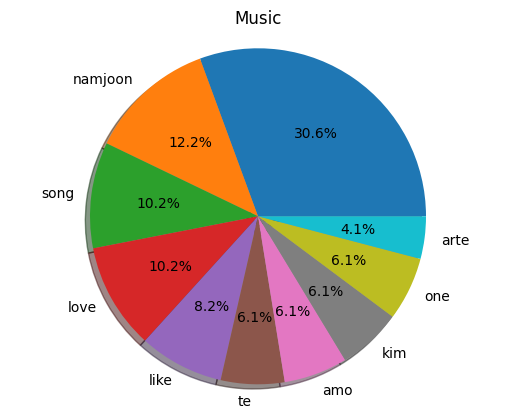

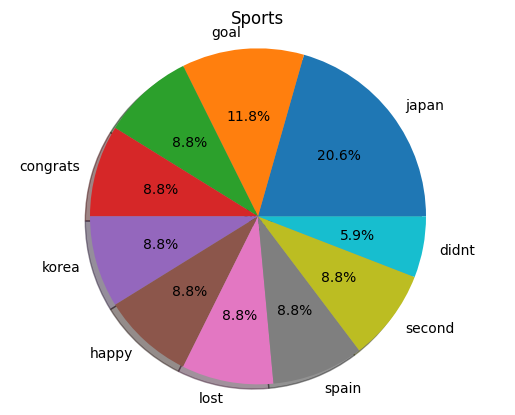

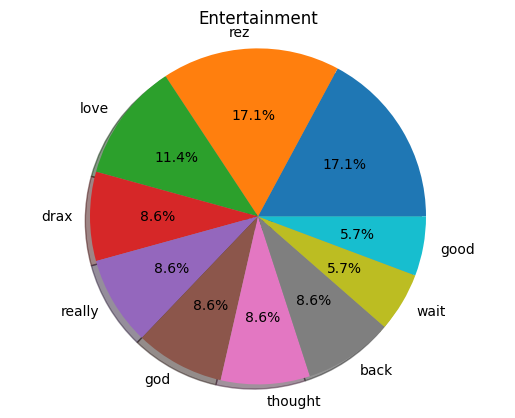

In [115]:
def top_words_per_tag(count=10):
    tags_counder = {}
    for v in videos.values():
        for s in v.comments:
            for w in s.split():
                w = re.sub(r'[^\w]', '', w).lower()
                if w not in stop_words:
                    if int(v.category_id) not in tags_counder:
                        tags_counder[int(v.category_id)] = [w]
                    else: tags_counder[int(v.category_id)].append(w)
    for t in tags:
        if t not in tags_counder:
            continue
        
        most_common_words_tuple = collections.Counter(tags_counder[t]).most_common(count)
        common_words, counts = [i[0] for i in most_common_words_tuple], [i[1] for i in most_common_words_tuple]
        plt.title(id_to_tag[t])
        plt.pie(counts, labels=common_words, 
                autopct='%1.1f%%', shadow=True)
        plt.axis('equal')
        plt.show()
top_words_per_tag(10)

In [121]:
def sentiment_per_tag():
    # predict_small
    tags_sent_dict = {}
    for v in videos.values():
        for s in v.comments:
            pred = predict_small(s)
            if int(v.category_id) not in tags_sent_dict:
                tags_sent_dict[int(v.category_id)] = {0:0,1:1} if pred else {0:1,1:0} 
            else: 
                tags_sent_dict[int(v.category_id)][pred] +=1
    
    return tags_sent_dict
tags_sent_dict = sentiment_per_tag()

In [127]:
tags_sent_dict

{24: {0: 9, 1: 21}, 1: {0: 6, 1: 4}, 17: {0: 9, 1: 11}, 10: {0: 10, 1: 30}}

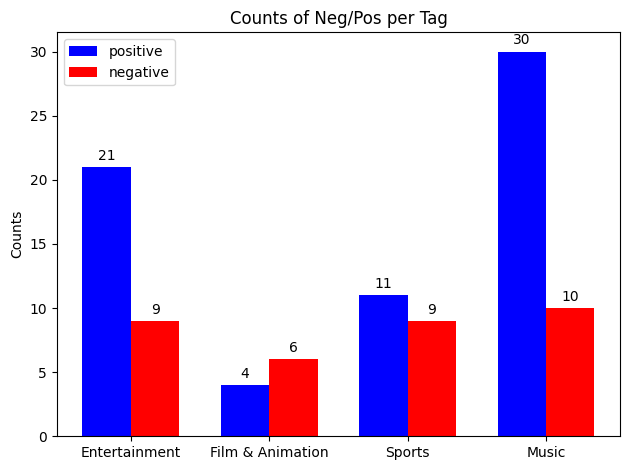

In [140]:

labels = [id_to_tag[v] for v in tags_sent_dict.keys()]
pos = [val[1] for val in tags_sent_dict.values()]
negs = [val[0] for val in tags_sent_dict.values()]
width = 0.35       # the width of the bars: can also be len(x) sequence

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
pos_bar = ax.bar(x - width/2, pos, width, label='positive', color='blue')
neg_bar = ax.bar(x + width/2, negs, width, label='negative', color='red')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Counts')
ax.set_title('Counts of Neg/Pos per Tag')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(pos_bar, padding=3)
ax.bar_label(neg_bar, padding=3)

fig.tight_layout()

plt.show()